In [135]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder


import warnings
warnings.filterwarnings("ignore")

In [136]:
train_labeled = pd.read_csv('data/labled_train_data.csv', index_col=0, sep='\t', comment='#')
comments_labeled = pd.read_csv('data/labled_train_comments.csv', index_col=0, sep='\t', comment='#')
tracks_labeled = pd.read_csv('data/labled_train_tracks.csv', index_col=0, sep='\t', comment='#')

train_unlabeled = pd.read_csv('data/unlabled_train_data.csv', index_col=0, sep='\t', comment='#')
comments_unlabeled = pd.read_csv('data/unlabled_train_comments.csv', index_col=0, sep='\t', comment='#')
tracks_unlabeled = pd.read_csv('data/unlabled_train_tracks.csv', index_col=0, sep='\t', comment='#')

In [137]:
X = train_labeled.iloc[:, :-1]
y = train_labeled.iloc[:, -1:]

In [138]:
X['client_rate_ride'] = X['client_rate_ride'].fillna(X['client_rate_ride'].mean())
X['client_rides_cnt'] = X['client_rides_cnt'].fillna(X['client_rides_cnt'].mean())
X['driver_rides_cnt'] = X['driver_rides_cnt'].fillna(X['driver_rides_cnt'].mean())

In [139]:
X

,order_id,driver_id,client_id,dttm,date,arrived_distance,arrived_duration,distance,duration,from_latitude,from_longitude,to_latitude,to_longitude,mark,client_rate_ride,client_rides_cnt,driver_rides_cnt,comment
0,6a0f322ade1a05e5c4cec4344efbce8b,f7c2b293ef94420f5e51abae6889b83b,3156d05c6458a8228bed59f02075a61e,2021-01-22 21:53:00,2021-01-22,150.0,1.0,11.8,20.5,55.795900,37.560300,55.716502,37.524627,Kia K5,4.877908,16.0,39.0,Больше нечего сказать
1,934ecbe5845426fd3f8ef7938cce2a11,01d029c42c99581080a60679fca06ff9,3156d05c6458a8228bed59f02075a61e,2021-01-24 14:09:00,2021-01-24,570.0,1.0,17.2,26.2,55.716502,37.524627,55.808253,37.638847,Volkswagen Polo,4.877908,18.0,338.0,Да
2,5348cb339b63eaea3b2cb57a064ce550,3c88deb7df7a73a24ebc229db9783405,3156d05c6458a8228bed59f02075a61e,2021-01-26 21:02:00,2021-01-26,40.0,0.0,5.8,10.9,55.716637,37.524223,55.741958,37.568172,MercedesBenz EClass,4.877908,17.0,162.0,Больше нечего сказать
3,309ef91c3b51e27d097642169576f67b,f35a8ff85f2095755f16bba91035fbdc,3156d05c6458a8228bed59f02075a61e,2021-01-27 17:24:00,2021-01-27,140.0,1.0,4.5,10.7,55.689076,37.491088,55.716502,37.524627,Kia Optima,4.877908,18.0,136.0,Больше нечего сказать
4,3506e04e45d39c6e3033637389da1041,0a227ac8d702170c03acf36d55e60d0d,3156d05c6458a8228bed59f02075a61e,2021-01-29 15:31:00,2021-01-29,150.0,1.0,15.4,25.1,55.655489,37.616629,55.716502,37.524627,Kia Rio,5.000000,20.0,194.0,Больше нечего сказать
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,bd1c7382bcfa4f5981a8b98d50cdbf37,f60352f28fc0b03c54e1e389519945eb,183c8d2838e8800609793f5925479f8c,2021-04-03 14:17:21,2021-04-03,0.0,0.0,20.5,42.6,55.711662,37.758961,55.748140,37.538721,Kia Optima,5.000000,14.0,79.0,Больше нечего сказать
8996,37a2c7ddf4e0e911d1f5b827a22424c6,52c7c1b99bf9eec8c36a3a852f4208a6,a3555aa482365082065ddbe2b60b7944,2021-04-03 14:17:44,2021-04-03,10.0,0.0,12.1,26.2,55.739415,37.649726,55.816200,37.631172,Lada Vesta,4.877908,38.0,383.0,На заднем сиденье жёлтые полосы и пятна остали...
8997,675f5308235dfb532bc12c628568a431,36a26e1bdad8ffa82020449e4c670f0d,e5070710fc47d467ebc6488eeceed19a,2021-04-03 14:24:30,2021-04-03,60.0,0.0,3.9,11.4,55.739262,37.633640,55.747094,37.605861,Kia Ceed,4.877908,14.0,38.0,Больше нечего сказать
8998,209184a3e7d4cff49703e03ea9329ce7,68a076cc5bb1e50a25086baa275af6a0,35fae1e96d973ac127e8bfa7859f1964,2021-04-03 14:30:45,2021-04-03,2650.0,6.0,2.0,6.0,55.783070,37.578504,55.795784,37.584560,Kia Rio,4.877908,32.0,121.0,Больше нечего сказать


# Analysis

In [140]:
dataset_joined = X.join(y)

In [141]:
dataset_joined[dataset_joined.columns[3: ]]

,dttm,date,arrived_distance,arrived_duration,distance,duration,from_latitude,from_longitude,to_latitude,to_longitude,mark,client_rate_ride,client_rides_cnt,driver_rides_cnt,comment,is_aggressive
0,2021-01-22 21:53:00,2021-01-22,150.0,1.0,11.8,20.5,55.795900,37.560300,55.716502,37.524627,Kia K5,4.877908,16.0,39.0,Больше нечего сказать,0
1,2021-01-24 14:09:00,2021-01-24,570.0,1.0,17.2,26.2,55.716502,37.524627,55.808253,37.638847,Volkswagen Polo,4.877908,18.0,338.0,Да,0
2,2021-01-26 21:02:00,2021-01-26,40.0,0.0,5.8,10.9,55.716637,37.524223,55.741958,37.568172,MercedesBenz EClass,4.877908,17.0,162.0,Больше нечего сказать,0
3,2021-01-27 17:24:00,2021-01-27,140.0,1.0,4.5,10.7,55.689076,37.491088,55.716502,37.524627,Kia Optima,4.877908,18.0,136.0,Больше нечего сказать,0
4,2021-01-29 15:31:00,2021-01-29,150.0,1.0,15.4,25.1,55.655489,37.616629,55.716502,37.524627,Kia Rio,5.000000,20.0,194.0,Больше нечего сказать,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,2021-04-03 14:17:21,2021-04-03,0.0,0.0,20.5,42.6,55.711662,37.758961,55.748140,37.538721,Kia Optima,5.000000,14.0,79.0,Больше нечего сказать,0
8996,2021-04-03 14:17:44,2021-04-03,10.0,0.0,12.1,26.2,55.739415,37.649726,55.816200,37.631172,Lada Vesta,4.877908,38.0,383.0,На заднем сиденье жёлтые полосы и пятна остали...,0
8997,2021-04-03 14:24:30,2021-04-03,60.0,0.0,3.9,11.4,55.739262,37.633640,55.747094,37.605861,Kia Ceed,4.877908,14.0,38.0,Больше нечего сказать,0
8998,2021-04-03 14:30:45,2021-04-03,2650.0,6.0,2.0,6.0,55.783070,37.578504,55.795784,37.584560,Kia Rio,4.877908,32.0,121.0,Больше нечего сказать,0


### Comments

Как много комментариев было оставлено в случае агрессивной поездки?

In [142]:
print("{}%".format((1 - sum(dataset_joined[dataset_joined.is_aggressive == True].comment == 'Больше нечего сказать') / \
len(dataset_joined[dataset_joined.is_aggressive == True])) * 100))

43.28703703703704%


А в случае неагрессивной?

In [143]:
print("{}%".format((1 - sum(dataset_joined[dataset_joined.is_aggressive == False].comment == 'Больше нечего сказать') / \
len(dataset_joined[dataset_joined.is_aggressive == False])) * 100))

13.935574229691872%


In [144]:
comment_phrases = list(dataset_joined.comment.value_counts().index[: 10])

In [145]:
dataset_joined['is_comment'] = (~np.isin(dataset_joined.comment, comment_phrases)).astype(int)

Как много агрессивных поездок среди содержащих комментарий?

In [146]:
print("{}%".format(sum(dataset_joined[(dataset_joined.is_comment == True)].is_aggressive == True) \
                   / len(dataset_joined[(dataset_joined.is_comment == True)]) * 100))

17.13747645951036%


In [147]:
(dataset_joined[(dataset_joined.is_comment == 1) & (dataset_joined.is_aggressive == 1)].comment).iloc[8]

'Очень вежливый'

In [148]:
aggresive_comments = dataset_joined[(dataset_joined['is_comment'] == True) & (dataset_joined.is_aggressive == True)].comment.values

#### Anxious words

In [149]:
expection_words = ['на', 'по', 'с', 'в', 'что', 'и']

In [150]:
from collections import Counter

counter = Counter()

for sentence in aggresive_comments:
    for word in sentence.split(" "):
        if (word in expection_words): continue
        counter[word] += 1


In [151]:
counter

Counter({'выезжал': 1,
         'встречку': 1,
         'несколько': 6,
         'раз': 9,
         'салон': 4,
         'весь': 1,
         'прокурен.': 1,
         'после': 3,
         'поездки': 6,
         'пахнут': 1,
         'волосы': 1,
         'одежда': 1,
         'Точка': 1,
         'фактической': 1,
         'подачи': 3,
         'машины': 9,
         'отличалась': 1,
         'от': 9,
         'точки,': 3,
         'которую': 1,
         'я': 11,
         'выставляла': 1,
         'приложении': 3,
         'Ошибся': 1,
         'первом': 1,
         'вопросе,': 1,
         'номер': 4,
         'отличается,': 1,
         'хотя': 2,
         'похож': 1,
         'Плохо': 2,
         'понимает': 1,
         'по-русски': 1,
         'Хамоватый': 1,
         'водитель,': 2,
         'который': 2,
         'ездит': 1,
         'очень': 22,
         'агрессивно': 3,
         'опасно': 3,
         'Агрессивная': 3,
         'манера': 11,
         'вождения': 5,
         'Очень':

In [152]:
counter_sorted = sorted(counter.items(), key = lambda x: x[1], reverse = True)

In [153]:
counter_sorted[:10]

[('не', 85),
 ('Водитель', 32),
 ('водитель', 24),
 ('очень', 22),
 ('Очень', 17),
 ('был', 17),
 ('во', 12),
 ('за', 12),
 ('было', 12),
 ('я', 11)]

In [154]:
anxiouns_words = list(map(lambda x: x[0], counter_sorted[: 10]))

anxiouns_words

['не',
 'Водитель',
 'водитель',
 'очень',
 'Очень',
 'был',
 'во',
 'за',
 'было',
 'я']

In [155]:
dataset_joined['anxiouns_word'] = dataset_joined.comment.apply(lambda x: len(set(anxiouns_words) & set(x)) > 0)

Сколько среди всех поездок, в описании которых есть тревожные слова, агрессивных?

In [156]:
sum(dataset_joined[(dataset_joined.anxiouns_word == True)].is_aggressive == True) / len(dataset_joined[(dataset_joined.anxiouns_word == True)])

0.20318725099601595

### Numerical features

Средняя дальность поездки с агрессивным и обычным водителем

In [157]:
dataset_joined[dataset_joined.is_aggressive == True].distance.mean(), dataset_joined[dataset_joined.is_aggressive == False].distance.mean()

(13.435185185185187, 11.06733193277315)

Средняя продолжительность поездки с агрессивным и обычным водителем

In [158]:
dataset_joined[dataset_joined.is_aggressive == True].duration.mean(), dataset_joined[dataset_joined.is_aggressive == False].duration.mean()

(26.735648148148158, 22.129236694677886)

Мода марки машины агрессивного и обычного водителя(hyundai просто самая популярная, так что изменения не налицо)

In [159]:
dataset_joined[dataset_joined.is_aggressive == True].mark.value_counts().index[0], dataset_joined[dataset_joined.is_aggressive == False].mark.value_counts().index[0]

('Hyundai Solaris', 'Hyundai Solaris')

Все марки машин

In [160]:
dataset_joined[dataset_joined.is_aggressive == True].mark.value_counts(), dataset_joined[dataset_joined.is_aggressive == False].mark.value_counts()

(Hyundai Solaris         94
 Skoda Octavia           59
 Kia Rio                 58
 Kia Optima              43
 Volkswagen Polo         36
 Skoda Rapid             22
 Toyota Camry            18
 Ford Focus              18
 Kia Ceed                14
 Hyundai Elantra          9
 Hyundai Sonata           8
 Nissan Almera            6
 Kia K5                   6
 Lada Vesta               5
 Volkswagen Jetta         4
 Hyundai i40              4
 Ford Galaxy              3
 Renault Logan            3
 Chevrolet Cruze          2
 Kia Cerato               2
 MercedesBenz EClass      2
 Lifan Solano 2           1
 Skoda Kodiaq             1
 Chevrolet Orlando        1
 Renault Sandero          1
 Lexus ES                 1
 Renault Scenic           1
 Ford Mondeo              1
 Mitsubishi Outlander     1
 LADA ВАЗ Vesta           1
 BMW 5 серия              1
 Kia Ceed Sportswagon     1
 BMW 5er                  1
 Daewoo Gentra            1
 RAVON R4                 1
 Hyundai H1         

Средняя оценка поездки пассажиром(у агрессивных поездок оценка ниже, но не сильно => видимо, агрессивность оценивает не пассажир)

In [161]:
dataset_joined[dataset_joined.is_aggressive == True].client_rate_ride.mean(), dataset_joined[dataset_joined.is_aggressive == False].client_rate_ride.mean()

(4.735102079475958, 4.885108231270127)

Количество поездок пассажира с агрессивным/неагрессивным водителем(не должно влиять, ведь оценку агрессивности, по-видимому, выдает не пассажир)

In [162]:
dataset_joined[dataset_joined.is_aggressive == True].client_rides_cnt.mean(), dataset_joined[dataset_joined.is_aggressive == False].client_rides_cnt.mean()

(23.979166666666668, 25.881293133875513)

Среднее количетсво поездок агрессивного/неагрессивного водителя

In [163]:
dataset_joined[dataset_joined.is_aggressive == True].driver_rides_cnt.mean(), dataset_joined[dataset_joined.is_aggressive == False].driver_rides_cnt.mean()

(172.13848877799202, 177.31195338518717)

## Time

In [164]:
dataset_joined['dttm'] = pd.to_datetime(dataset_joined.dttm)

### Hour

In [165]:
dataset_joined['hour'] = dataset_joined.dttm.apply(lambda x: x.hour)

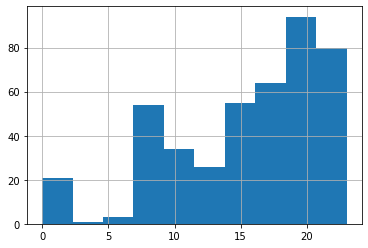

In [166]:
dataset_joined[dataset_joined.is_aggressive == True].hour.hist()

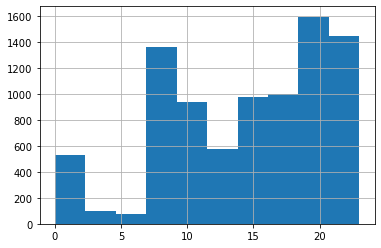

In [167]:
dataset_joined[dataset_joined.is_aggressive == False].hour.hist()

In [168]:
dataset_traffjam = dataset_joined[((dataset_joined.hour > 6) & (dataset_joined.hour < 10)) | ((dataset_joined.hour > 17) & (dataset_joined.hour < 23))]

In [169]:
dataset_notraffjam = dataset_joined[~(((dataset_joined.hour > 6) & (dataset_joined.hour < 10)) | ((dataset_joined.hour > 17) & (dataset_joined.hour < 23)))]

In [170]:
(dataset_traffjam.is_aggressive == True).sum() / len(dataset_traffjam)

0.0499378367177787

In [171]:
(dataset_notraffjam.is_aggressive == True).sum() / len(dataset_notraffjam)

0.045759463344513654

### Month

In [172]:
dataset_joined['month'] = dataset_joined.dttm.apply(lambda x: x.month)

In [173]:
dataset_joined.month.value_counts()

3    4663
2    2597
1    1263
4     477
Name: month, dtype: int64

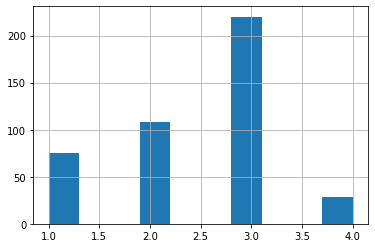

In [174]:
dataset_joined[(dataset_joined.is_aggressive == True)].month.hist()

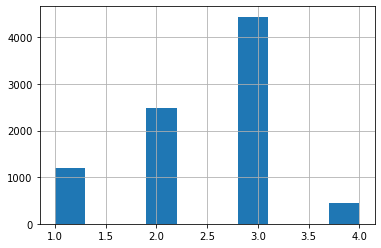

In [175]:
dataset_joined[(dataset_joined.is_aggressive == False)].month.hist()

### Weekday

In [176]:
dataset_joined.dttm.iloc[0].weekday()

4

In [177]:
dataset_joined['weekday'] = dataset_joined.dttm.apply(lambda x: x.weekday())

In [178]:
dataset_joined['holiday'] = (dataset_joined.weekday >= 5).astype(int)

In [179]:
dataset_joined[(dataset_joined.holiday == 1)].is_aggressive.sum() / len(dataset_joined[(dataset_joined.holiday == 1)])

0.04805683242791475

In [180]:
(dataset_joined[(dataset_joined.holiday != 1)].is_aggressive.astype(bool)).sum() / len(dataset_joined[(dataset_joined.holiday != 1)])

0.04797941577115181

# Features generation

In [181]:
comment_phrases = list(X.comment.value_counts().index[: 10])

In [182]:
comment_phrases

['Больше нечего сказать',
 'Да',
 'Все хорошо',
 'Все ок',
 'Нет',
 'Отличный водитель',
 'Хороший водитель',
 'Все отлично',
 'Отличный водитель!',
 'Ок']

In [183]:
X["is_comment"] = (~np.isin(X.comment, comment_phrases)).astype(int)

In [184]:
X[X.is_comment == True].comment

28                         Отличный водитель!!!Спасибо!!!
29                          Лучший водитель!!! Спасибо!!!
35      водитель заехал и сразу встал с той стороны до...
36      постоянно отвлекался на поиск и просмотр ролик...
43                      выезжал на встречку несколько раз
                              ...                        
8965                                          Всё отлично
8967    Водитель приятный в общении. Но показалось, чт...
8975    Говорил по телефону во время движения, делал о...
8989    Отличный водитель, помог нам найти более корот...
8996    На заднем сиденье жёлтые полосы и пятна остали...
Name: comment, Length: 1062, dtype: object

In [185]:
X['dttm'] = pd.to_datetime(X.dttm)

In [186]:
X['hour'] = X.dttm.apply(lambda x: x.hour)

In [187]:
X['traff_jam'] = ((X.hour > 6) & (X.hour < 10)) | ((X.hour > 17) & (X.hour < 23))
X['traff_jam'] = X.traff_jam.astype(int)

In [188]:
X['weekday'] = X.dttm.apply(lambda x: x.weekday())
X['holiday'] = (X.weekday >= 5).astype(int)

In [191]:
X['anxiouns_word'] = X.comment.apply(lambda x: int(len(set(anxiouns_words) & set(x)) > 0))

In [195]:
X

,order_id,driver_id,client_id,dttm,date,arrived_distance,arrived_duration,distance,duration,from_latitude,...,client_rate_ride,client_rides_cnt,driver_rides_cnt,comment,is_comment,hour,traff_jam,weekday,holiday,anxiouns_word
0,6a0f322ade1a05e5c4cec4344efbce8b,f7c2b293ef94420f5e51abae6889b83b,3156d05c6458a8228bed59f02075a61e,2021-01-22 21:53:00,2021-01-22,150.0,1.0,11.8,20.5,55.795900,...,4.877908,16.0,39.0,Больше нечего сказать,0,21,1,4,0,0
1,934ecbe5845426fd3f8ef7938cce2a11,01d029c42c99581080a60679fca06ff9,3156d05c6458a8228bed59f02075a61e,2021-01-24 14:09:00,2021-01-24,570.0,1.0,17.2,26.2,55.716502,...,4.877908,18.0,338.0,Да,0,14,0,6,1,0
2,5348cb339b63eaea3b2cb57a064ce550,3c88deb7df7a73a24ebc229db9783405,3156d05c6458a8228bed59f02075a61e,2021-01-26 21:02:00,2021-01-26,40.0,0.0,5.8,10.9,55.716637,...,4.877908,17.0,162.0,Больше нечего сказать,0,21,1,1,0,0
3,309ef91c3b51e27d097642169576f67b,f35a8ff85f2095755f16bba91035fbdc,3156d05c6458a8228bed59f02075a61e,2021-01-27 17:24:00,2021-01-27,140.0,1.0,4.5,10.7,55.689076,...,4.877908,18.0,136.0,Больше нечего сказать,0,17,0,2,0,0
4,3506e04e45d39c6e3033637389da1041,0a227ac8d702170c03acf36d55e60d0d,3156d05c6458a8228bed59f02075a61e,2021-01-29 15:31:00,2021-01-29,150.0,1.0,15.4,25.1,55.655489,...,5.000000,20.0,194.0,Больше нечего сказать,0,15,0,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,bd1c7382bcfa4f5981a8b98d50cdbf37,f60352f28fc0b03c54e1e389519945eb,183c8d2838e8800609793f5925479f8c,2021-04-03 14:17:21,2021-04-03,0.0,0.0,20.5,42.6,55.711662,...,5.000000,14.0,79.0,Больше нечего сказать,0,14,0,5,1,0
8996,37a2c7ddf4e0e911d1f5b827a22424c6,52c7c1b99bf9eec8c36a3a852f4208a6,a3555aa482365082065ddbe2b60b7944,2021-04-03 14:17:44,2021-04-03,10.0,0.0,12.1,26.2,55.739415,...,4.877908,38.0,383.0,На заднем сиденье жёлтые полосы и пятна остали...,1,14,0,5,1,1
8997,675f5308235dfb532bc12c628568a431,36a26e1bdad8ffa82020449e4c670f0d,e5070710fc47d467ebc6488eeceed19a,2021-04-03 14:24:30,2021-04-03,60.0,0.0,3.9,11.4,55.739262,...,4.877908,14.0,38.0,Больше нечего сказать,0,14,0,5,1,0
8998,209184a3e7d4cff49703e03ea9329ce7,68a076cc5bb1e50a25086baa275af6a0,35fae1e96d973ac127e8bfa7859f1964,2021-04-03 14:30:45,2021-04-03,2650.0,6.0,2.0,6.0,55.783070,...,4.877908,32.0,121.0,Больше нечего сказать,0,14,0,5,1,0


# Train

In [196]:
X = X[['arrived_distance', 'arrived_duration', 'distance', 'duration', 'driver_rides_cnt', 'client_rides_cnt', 'client_rate_ride', 'mark', 'is_comment', 'traff_jam', 'weekday', 'anxiouns_word']]

best score: 0.7293

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_features = ['arrived_distance', 'arrived_duration', 'distance', 'duration',  'driver_rides_cnt', 'client_rides_cnt', 'client_rate_ride']
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# categorical_features = ['mark', 'is_comment', 'traff_jam', 'weekday']
categorical_features = ['mark', 'is_comment', 'traff_jam', 'weekday', 'anxiouns_word']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# clf = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier', LogisticRegression(max_iter=1000))])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', CatBoostClassifier(iterations = 2000, 
                                                        depth = 2,
                                                        silent = True))])

scores = cross_validate(clf, X_train, y_train, scoring='roc_auc', cv=5)

print(f'Средний скор на кросс-валидации {np.mean(scores["test_score"])}')

Средний скор на кросс-валидации 0.7293474361622334
